In [7]:
from fcn8s_tensorflow import FCN8s
from batch_generator import batch_generator
from visualization_utils import print_segmentation_onto_image

from math import ceil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = FCN8s(model_load_dir='saved_model_(globalstep-665)_(trainloss-0.0629)_(eval_on_val_dataset)_(loss-0.0717)_(mean_iou-0.5206)_(accuracy-0.7058)',
              tags=['default'],
              vgg16_dir='../../Google Drive/GitHub/Trained Models/VGG-16_mod2FCN_ImageNet-Classification',
              num_classes=2)

TensorFlow Version: 1.3.0
INFO:tensorflow:Restoring parameters from b'saved_model_(globalstep-665)_(trainloss-0.0629)_(eval_on_val_dataset)_(loss-0.0717)_(mean_iou-0.5206)_(accuracy-0.7058)/variables/variables'


In [6]:
epochs = 20
batch_size = 16
train_dataset_size = 289

train_generator = batch_generator(batch_size=batch_size,
                                  dataset_rootdir='../../datasets/KITTI_Vision/Road-Lane_Detection_2013/data_road/training/',
                                  images_subdir='image_2',
                                  labels_subdir='gt_image_2',
                                  image_size=(160, 576),
                                  flip=0.5)

def learning_rate_schedule(step):
    if step <= 200: return 0.001
    elif 200 < step <= 500: return 0.0003
    elif 500 < step <= 800: return 0.0001
    else: return 0.00003
    
model.train(train_generator=train_generator,
            epochs=epochs,
            steps_per_epoch=ceil(train_dataset_size/batch_size),
            learning_rate_schedule=learning_rate_schedule,
            keep_prob=0.5,
            eval_dataset='val',
            eval_frequency=5,
            val_generator=train_generator,
            val_steps=ceil(train_dataset_size/batch_size),
            metrics=['loss', 'accuracy', 'mean_iou'],
            save_during_training=True,
            save_dir='',
            save_best_only=True,
            save_tags=['default'],
            save_frequency=5,
            monitor='mean_iou',
            record_summaries=True,
            summaries_frequency=10,
            summaries_dir='tensorboard_log',
            training_loss_display_averaging=3)

Default GPU Device: /gpu:0
Evaluation on validation dataset: 100%|██████████| 19/19 [00:46<00:00,  1.89s/it]
loss: 0.0671  mean_iou: 0.5041  accuracy: 0.6939  
No improvement over previous best mean_iou value, not saving model.
Evaluation on validation dataset: 100%|██████████| 19/19 [00:47<00:00,  1.88s/it]
loss: 0.0627  mean_iou: 0.5078  accuracy: 0.6966  
No improvement over previous best mean_iou value, not saving model.
Evaluation on validation dataset: 100%|██████████| 19/19 [00:46<00:00,  1.88s/it]
loss: 0.0612  mean_iou: 0.5172  accuracy: 0.7034  
No improvement over previous best mean_iou value, not saving model.
Evaluation on validation dataset: 100%|██████████| 19/19 [00:47<00:00,  1.88s/it]
loss: 0.0600  mean_iou: 0.5181  accuracy: 0.7040  
No improvement over previous best mean_iou value, not saving model.


In [3]:
model.save(model_save_dir='',
           tags=['default'],
           name=None,
           include_global_step=True,
           include_last_training_loss=True,
           include_metrics=True)

Abort: Nothing to save, no training has been performed since the model was last saved.


In [8]:
model.predict_and_save(results_dir='test_results',
                       images_dir='../../datasets/KITTI_Vision/Road-Lane_Detection_2013/data_road/testing/image_2',
                       image_size=(160, 576),
                       color_map={1: (0, 255, 0, 127)})

The segmented images will be saved to "test_results"
Processing images: 100%|██████████| 290/290 [00:39<00:00,  7.53it/s]


In [3]:
batch_size = 16
dataset_size = 289

data_generator = batch_generator(batch_size=batch_size,
                                 dataset_rootdir='../../datasets/KITTI_Vision/Road-Lane_Detection_2013/data_road/training/',
                                 images_subdir='image_2',
                                 labels_subdir='gt_image_2',
                                 image_size=(160, 576),
                                 flip=False)

model.evaluate(data_generator=data_generator,
               metrics=['loss', 'accuracy'],
               num_batches=ceil(dataset_size/batch_size))

Running evaluation: 100%|██████████| 19/19 [00:15<00:00,  1.57it/s]
loss: 0.0719  accuracy: 0.7055  


In [9]:
batch_size = 16

data_generator = batch_generator(batch_size=batch_size,
                                 dataset_rootdir='../../datasets/KITTI_Vision/Road-Lane_Detection_2013/data_road/training/',
                                 images_subdir='image_2',
                                 labels_subdir='gt_image_2',
                                 image_size=(160, 576),
                                 flip=False)

In [10]:
images, labels = next(data_generator)

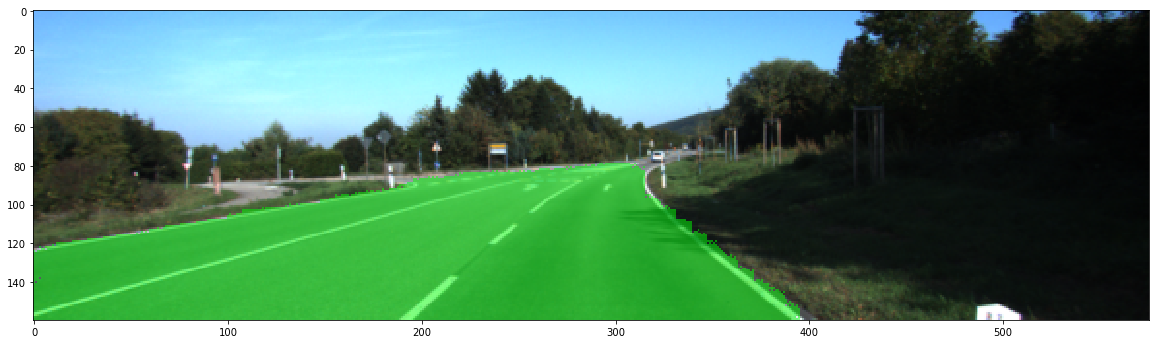

In [11]:
n = 0

prediction = model.predict([images[n]])

segmented_image = print_segmentation_onto_image(images[n], prediction, color_map={1: (0, 255, 0, 127)})

plt.figure(figsize=(20,14))
plt.imshow(segmented_image)

In [10]:
# Don't forget to close the session when you're done to release resources.

model.close()

The session has been closed.
